## Introduction
Mobile application - a utility for scanning documents. The monetization model is subscription, there is a trial period of 7 days with a further transition to payment of 4.99 USD per week.

## Tasks

1. It is necessary to calculate the user's current LTV using a cohort analysis (cohorting event - registration of a trial period, a cohort represents the number of possible operations).

2. Predict what LTV will be for six months.

3. Build a graph that will display the actual LTV curve against the background of the predicted LTV curve.

4. Calculate ROMI for 4 weeks and for half a year, if the cost of attracting a paying user is 6 USD (ROMI should be taken operational, not accounting, the goal is to find out how our investments will pay off).

# Содержание

1. [Библиотеки, открытие данных,  общая информация, предобработка](#start)

    1.1 [Проверка на наличие пропусков и дубликатов, их обработка](#preprocessing)
    
    1.2 [Удаление ненужных столбцов](#cleaning)




2. [Расчёт LTV](#ltv)
 
    2.1 [Расчёт текущего LTV](#ltv_now)
    
    2.2 [Прогнозирование LTV](#ltv_6month)
    
    
    
3. [Расчёт ROMI](#romi)

    3.1 [Расчёт текущего ROMI](#romi_now)
    
    3.2 [Прогнозирование ROMI](#romi_6month)

<a id='start'></a>
## Библиотеки, открытие данных,  общая информация, предобработка

In [1]:
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from numpy import log
from random import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR9ry5ZaF5XFAUEEl8hh3ycNzAbi4RUo9KDbJMRujXa_4jhSX7EdIl0xNfGzLfRpg/pub?output=xlsx'
df = pd.read_excel(path)
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114200 entries, 0 to 114199
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   product_id       114200 non-null  object        
 1   quantity         114200 non-null  int64         
 2   is_trial_period  114200 non-null  bool          
 3   purchase_date    114200 non-null  datetime64[ns]
 4   user_id          114200 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(1)
memory usage: 3.6+ MB


<a id='preprocessing'></a>
### Проверка на наличие пропусков и дубликатов, их обработка

In [4]:
df.isna().sum()

product_id         0
quantity           0
is_trial_period    0
purchase_date      0
user_id            0
dtype: int64

In [5]:
df.duplicated().sum()

84

In [6]:
df = df[df.duplicated()!=True]
df.duplicated().sum()

0

<a id='cleaning'></a>
### Удаление ненужных столбцов

Посмотрим какие значения принимают данные в колонках product_id и quantity

In [7]:
df['product_id'].unique()

array(['1week_4.99_USD_subscription_7days_trial'], dtype=object)

In [8]:
df['quantity'].unique()

array([1], dtype=int64)

В обеих колонках всё время одинаковые значения. Удалим колонки за ненадобностью.

In [9]:
df = df.drop(['product_id', 'quantity'], axis=1)

<a id='ltv'></a>
## Расчёт LTV

<a id='ltv_now'></a>
### Расчёт текущего LTV

In [10]:
def get_ltv(
    df,  
    horizon_weeks,
    price,
):
    profiles = (
        df.sort_values(by=['user_id', 'purchase_date'])
        .groupby('user_id')
        .agg({'purchase_date':'first' })
        .rename(columns={'purchase_date': 'first_time'})
        .reset_index()  
    ) #выделяем дату подписки
    
    df_profiles = profiles.merge(
    df, on='user_id', how='left'
    )
    
    df_profiles['lifetime'] = (((df_profiles['purchase_date'] - df_profiles['first_time']).dt.days)/7)\
    .astype('uint8') #фиксируем лайфтайм
    
    #фиксируем сумму каждой покупки
    df_profiles['revenue'] = [0 if df_profiles['is_trial_period'][x] == True else price for x in range(len(df_profiles))] 
    
    #Поскольку подписка оплачивается еженедельно выделем неделю из даты регистрации
    df_profiles['first_time'] = df_profiles['first_time'].dt.week
    
    #отфильтруем данные в зависимости от заданного горизонта анализа
    last_date = df_profiles['first_time'].max()- (horizon_weeks-1)
    df_profiles = df_profiles.query('first_time <= @last_date')
    
    #посчитаем выручку для каждого лайфтайма с группировкой по дате старта когорты
    revenue_grouped = df_profiles.pivot_table(
    index=['first_time'], columns='lifetime', values='revenue', aggfunc='sum'
    )
    revenue = revenue_grouped.fillna(0).cumsum(axis=1) #выручка с накоплением
    
    #считаем размер когорты
    cohort_sizes = (
    df_profiles.groupby('first_time')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
    )
    
    #Объединяем размеры когорт и таблицу выручки
    revenue = cohort_sizes.merge(revenue, on='first_time', how='left').fillna(0)
    
    #считаем LTV (делим выручку на размер когорты)
    ltv = revenue.div(revenue['cohort_size'], axis=0)
    
    # исключаем все лайфтаймы, превышающие горизонт анализа
    ltv = ltv[['cohort_size'] + list(range(horizon_weeks))]
    revenue = revenue[['cohort_size'] + list(range(horizon_weeks))]
    # восстанавливаем размеры когорт
    revenue['cohort_size'] = cohort_sizes
    ltv['cohort_size'] = cohort_sizes
    return revenue, ltv

In [11]:
revenue, ltv = get_ltv(df, 4, 4.99)
ltv

,cohort_size,0,1,2,3
first_time,,,,,
1,6629,0.003764,1.936081,3.493527,4.882356
2,8429,0.002368,1.771275,3.212805,4.467261
3,9134,0.000000,1.750925,3.144017,4.325140
4,8185,0.000000,1.644231,2.876337,3.909697
5,8315,0.000600,1.630527,2.866775,3.321066


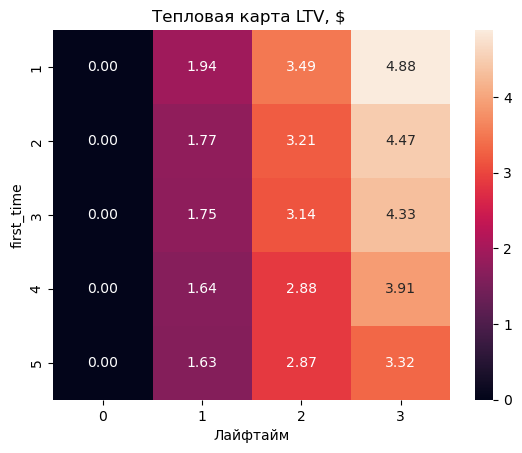

In [12]:
sns.heatmap(ltv.drop(columns=['cohort_size']), annot=True, fmt='.2f')
plt.title('Тепловая карта LTV, $ ')
plt.xlabel('Лайфтайм')
plt.show()

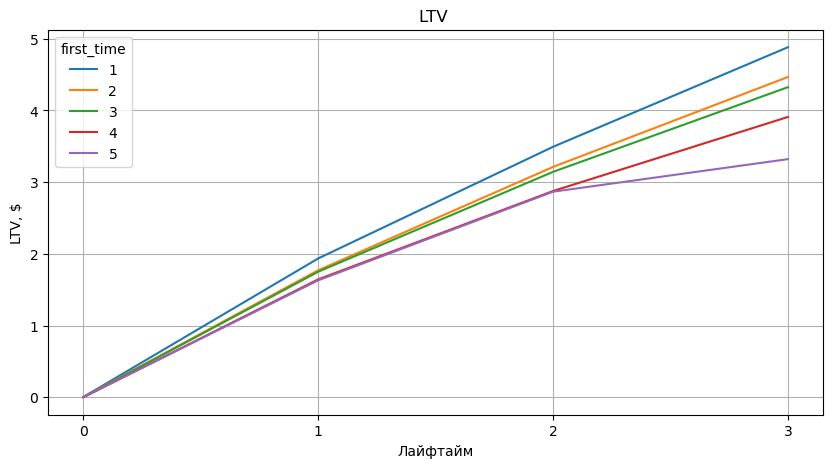

In [13]:
report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))
plt.title('LTV ')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')
plt.show()

<a id='ltv_6month'></a>
## Прогнозирование  LTV

Для прогноза применим логарифмическую и степенную функции подгонки кривой с помощью библиотеки scipy.curve_fit() и выберем лучшую

Для модели возьмём кривую LTV с наибольшим горизонтом анализа, в нашем случае 8 недель

In [14]:
revenue, ltv = get_ltv(df, 8, 4.99)
ltv

,cohort_size,0,1,2,3,4,5,6,7
first_time,,,,,,,,,
1,6629,0.003764,1.936081,3.493527,4.882356,6.125904,7.231699,8.171887,8.335987


In [15]:
ltv_f = ltv.drop(columns=['cohort_size']).T


In [16]:
X = ltv_f.index.values+1
Y = ltv_f[1].values

In [17]:
#зададим интервал в неделях. 6 месяцев - это 26 недель
t = np.arange(1, 26)

In [18]:
def logarithmic_function(t, a, b):
    return a*log(t) + b

In [19]:
def fit_curve(func, X, Y):
    
    popt = curve_fit(func, X, Y)
    X_fit = popt[0][0]
    Y_fit = popt[0][1]
    
    fit = []
    for i in t:
        fit.append(func(i, X_fit, Y_fit))
    return fit

In [20]:
log_fit = fit_curve(logarithmic_function, X, Y)

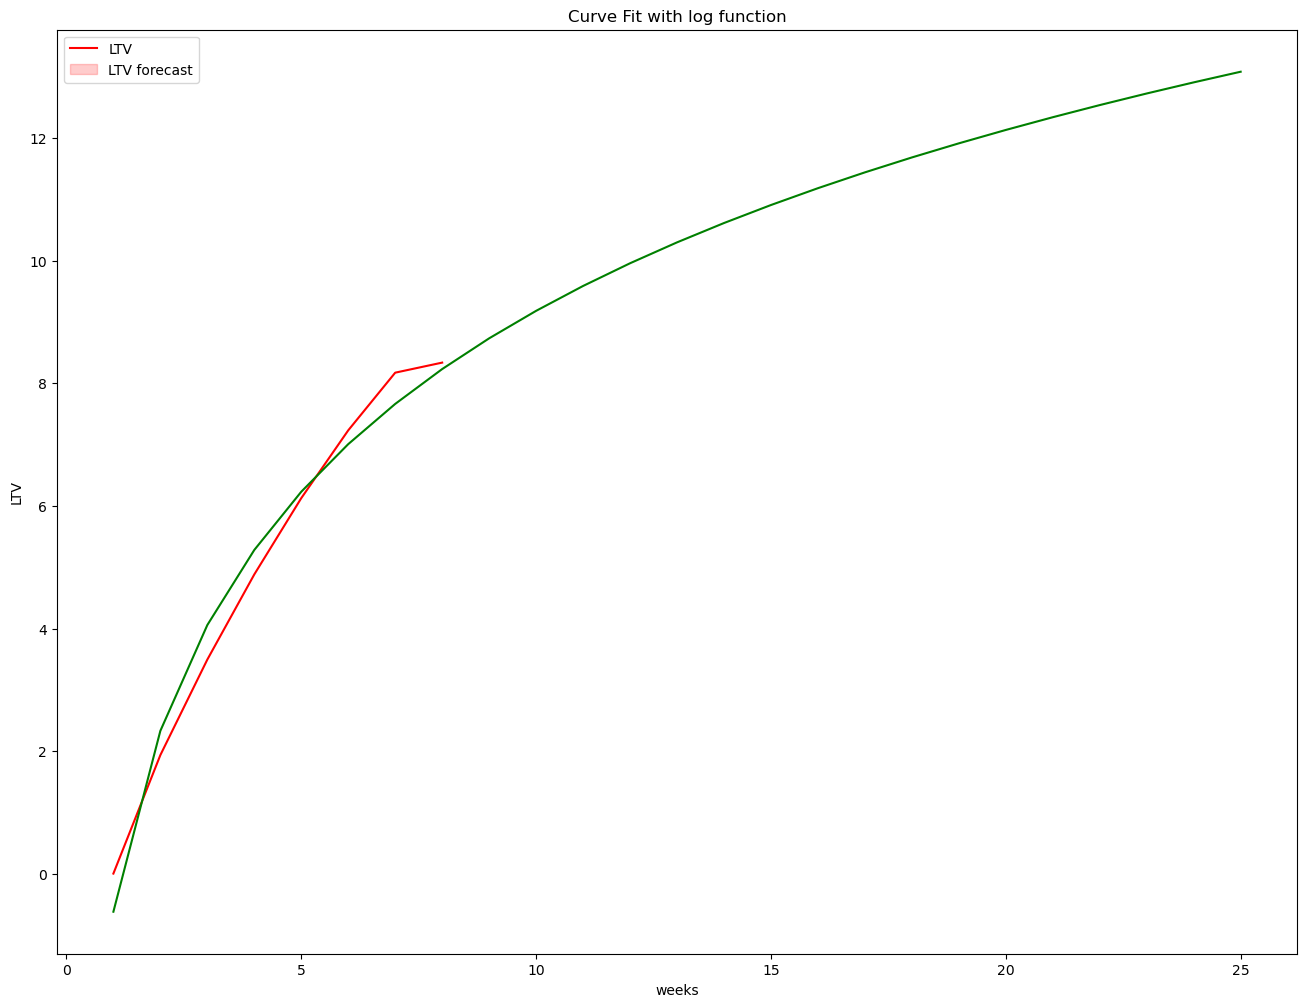

In [21]:
plt.figure(figsize=(16,12))
sns.lineplot(x=X, y=Y, color="r")
sns.lineplot(x=t, y=log_fit, color="g")
# plt.grid()
plt.xlabel("weeks")
plt.ylabel("LTV")
plt.title("Curve Fit with log function")
plt.legend(['LTV', 'LTV forecast'])
plt.show()

<a id='romi'></a>
## Расчёт ROMI

<a id='romi_now'></a>
### Расчёт текущего ROMI

In [26]:
def get_romi(
    df,  
    weeks,
    price,
    cost
):
    
    df = df.query('is_trial_period==False')
    
    profiles = (
        df.sort_values(by=['user_id', 'purchase_date'])
        .groupby('user_id')
        .agg({'purchase_date':'first' })
        .rename(columns={'purchase_date': 'first_time'})
        .reset_index()  
    )
    
    df_profiles = profiles.merge(
    df, on='user_id', how='left'
    )
    
    df_profiles['lifetime'] = (((df_profiles['purchase_date'] - df_profiles['first_time']).dt.days)/7)\
    .astype('uint8') #фиксируем лайфтайм


    #фиксируем сумму каждой покупки
    df_profiles['revenue'] = price 
    
    #Поскольку подписка оплачивается еженедельно выделем неделю из даты регистрации
    df_profiles['first_time'] = df_profiles['first_time'].dt.week
    
    if weeks > df_profiles['first_time'].max():
        return print('Назначьте неделю меньше или равно: ', df_profiles['first_time'].max())
    else:
        horizont_week = df_profiles['first_time'].max()-weeks+1
    #df_profiles = df_profiles.query('first_time <= @last_date')
        df_profiles = df_profiles.query('first_time <= @weeks')
    
    #посчитаем выручку для каждого лайфтайма с группировкой по дате старта когорты
        revenue_grouped = df_profiles.pivot_table(
        index=['first_time'], columns='lifetime', values='revenue', aggfunc='sum'
        )
        revenue = revenue_grouped.fillna(0).cumsum(axis=1) #выручка с накоплением
    
        #считаем размер когорты
        cohort_sizes = (
        df_profiles.groupby('first_time')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
        )
    
    #Объединяем размеры когорт и таблицу выручки
        revenue = cohort_sizes.merge(revenue, on='first_time', how='left').fillna(0)
    
    #считаем LTV (делим выручку на размер когорты)
        ltv = revenue.div(revenue['cohort_size'], axis=0)
    
    # исключаем все лайфтаймы, превышающие горизонт анализа
        ltv = ltv[['cohort_size'] + list(range(horizont_week-1))]
        romi = (ltv.drop(columns=['cohort_size'])-6)/6
        
        return romi

    return  romi

In [27]:
romi = get_romi(df, 4, 4.99, 6)

In [28]:
romi

,0,1,2,3
first_time,,,,
1,-0.168333,0.497000,0.996000,1.328667
2,-0.167996,0.488086,1.061102,1.566585
3,-0.168333,0.477757,1.022699,1.494452
4,-0.167829,0.458759,0.977888,1.422352


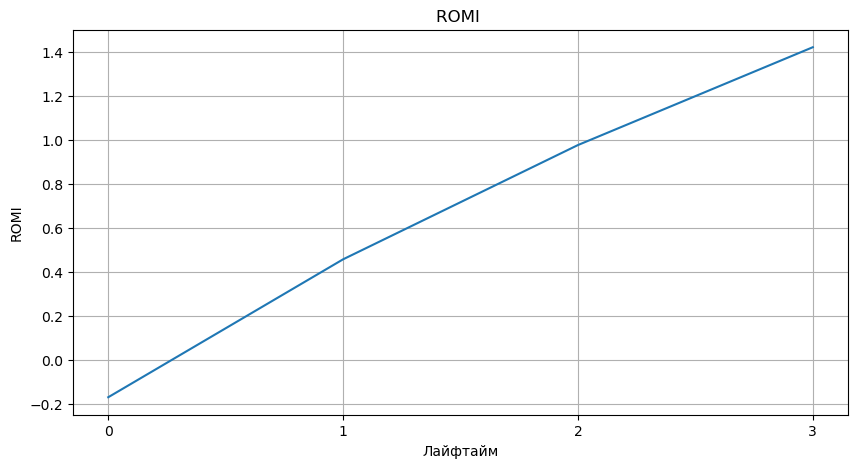

In [29]:
romi.loc[4].T.plot(grid=True, figsize=(10, 5), xticks=list(romi.columns.values))
plt.title('ROMI ')
plt.ylabel('ROMI')
plt.xlabel('Лайфтайм')
plt.show()

<a id='romi_6month'></a>
### Прогнозирование ROMI

In [30]:
romi = get_romi(df, 1, 4.99, 6).T

In [31]:
X = romi.index.values+1
Y = romi[1].values

In [32]:
#зададим интервал в неделях. 6 месяцев - это 26 недель
t = np.arange(1, 26)

In [33]:
def logarithmic_function(t, a, b):
    return a*log(t) + b

In [34]:
def fit_curve(func, X, Y):
    
    popt = curve_fit(func, X, Y)
    X_fit = popt[0][0]
    Y_fit = popt[0][1]
    
    fit = []
    for i in t:
        fit.append(func(i, X_fit, Y_fit))
    return fit

In [35]:
log_fit = fit_curve(logarithmic_function, X, Y)

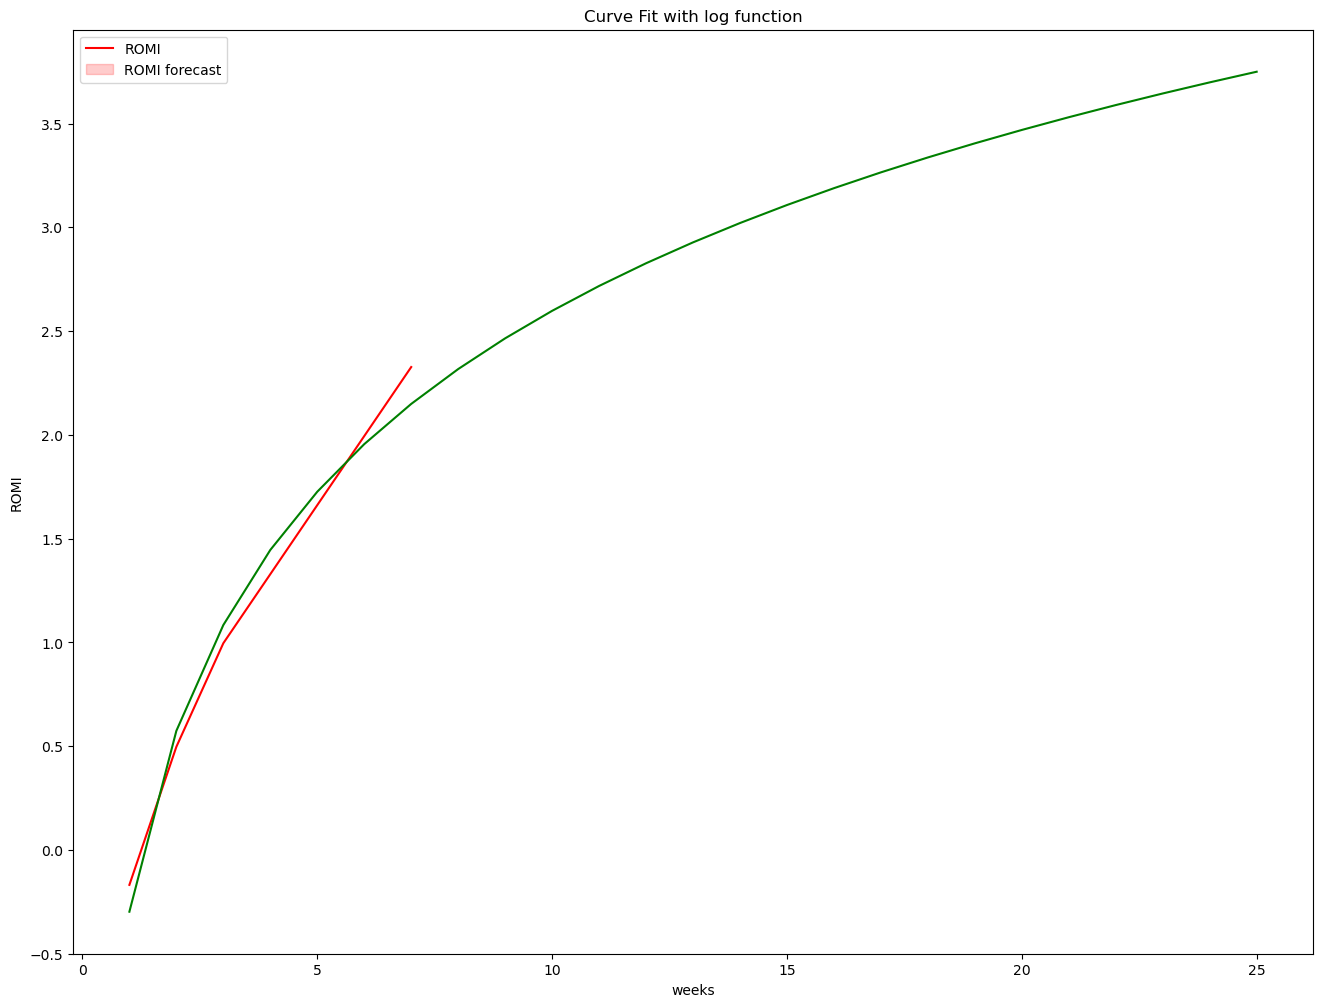

In [36]:
plt.figure(figsize=(16,12))
sns.lineplot(x=X, y=Y, color="r")
sns.lineplot(x=t, y=log_fit, color="g")
# plt.grid()
plt.xlabel("weeks")
plt.ylabel("ROMI")
plt.title("Curve Fit with log function")
plt.legend(['ROMI', 'ROMI forecast'])
plt.show()